# Linear regression model
# US county-level sociodemographic and health resource data

In [5]:
# Importar librerias

import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ( train_test_split, GridSearchCV )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import ( MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder )
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import (
        accuracy_score,
        f1_score,
        matthews_corrcoef,
        classification_report,
        ConfusionMatrixDisplay )
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from itertools import product
import pickle
import os
import joblib
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### **1. Data loading**
**Objective**: **Obtain the data from source and get a first glimpse of their properties and presentation

In [ ]:
# https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv

In [2]:
url = ('https://raw.githubusercontent.com/4GeeksAcademy/regularized-linear-regression-project-tutorial/main/demographic_health_data.csv')
df_raw = pd.read_csv(url, sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Columns: 108 entries, fips to Urban_rural_code
dtypes: float64(61), int64(45), object(2)
memory usage: 2.6+ MB


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [7]:
df_raw.head(10)

,fips,TOT_POP,0-9,0-9 y/o % of total pop,19-Oct,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,COUNTY_NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,county_pop2018_18 and older,anycondition_prevalence,anycondition_Lower 95% CI,anycondition_Upper 95% CI,anycondition_number,Obesity_prevalence,Obesity_Lower 95% CI,Obesity_Upper 95% CI,Obesity_number,Heart disease_prevalence,Heart disease_Lower 95% CI,Heart disease_Upper 95% CI,Heart disease_number,COPD_prevalence,COPD_Lower 95% CI,COPD_Upper 95% CI,COPD_number,diabetes_prevalence,diabetes_Lower 95% CI,diabetes_Upper 95% CI,diabetes_number,CKD_prevalence,CKD_Lower 95% CI,CKD_Upper 95% CI,CKD_number,Urban_rural_code
0,1001,55601,6787,12.206615,7637,13.735364,6878,12.370281,7089,12.749771,7582,13.636445,7738,13.917016,5826,10.478229,4050,7.284042,2014,3.622237,42660,76.725239,10915,19.630942,267,0.480207,681,1.224798,62,0.111509,1016,1.827305,55601,158,455,11.8,9.6,2.2,0.0,0.7,0.6,4204,12119,10552,10291,11.3,32.6,28.4,27.7,7587,13.8,19.3,19.5,59338,53628,65048,25957,25015,942,3.6,59338,119.0,217.1,196.7,77.2,71.2,7.6,6.9,28.859137,6.085786,1.148905,25.992561,21.249061,72.142154,6,55036,10523,19.1,Autauga,Alabama,1,1,42438,47.6,45.4,49.4,20181,35.8,34.2,37.3,15193,7.9,7.2,8.7,3345,8.6,7.3,9.9,3644,12.9,11.9,13.8,5462,3.1,2.9,3.3,1326,3
1,1003,218022,24757,11.355276,26913,12.344167,23579,10.814964,25213,11.564429,27338,12.539102,29986,13.753658,29932,13.728890,20936,9.602701,9368,4.296814,190301,87.285228,19492,8.940382,1684,0.772399,2508,1.150343,146,0.066966,3891,1.784682,218022,5403,2190,10.5,10.3,0.1,0.5,24.3,24.8,14310,40579,46025,46075,9.7,27.6,31.3,31.3,21069,9.8,13.9,13.1,57588,54437,60739,93849,90456,3393,3.6,57588,115.5,217.1,196.7,77.2,71.2,7.6,6.9,113.162114,23.863512,4.505074,101.921730,83.321572,282.882982,51,203360,53519,26.3,Baldwin,Alabama,1,3,170912,40.2,38.2,42.3,68790,29.7,28.4,31.0,50761,7.8,7.0,8.7,13414,8.6,7.2,10.1,14692,12.0,11.0,13.1,20520,3.2,3.0,3.5,5479,4
2,1005,24881,2732,10.980266,2960,11.896628,3268,13.134520,3201,12.865239,3074,12.354809,3278,13.174712,3076,12.3

In [8]:
print(f"Shape of raw dataset: {df_raw.shape}")

Shape of raw dataset: (3140, 108)


### **2. Data preprocessing**
**Objectives**: Perform the data cleaning, data transformation and data reduction steps to avoid data mistmatching, noisy data or data not wrangled

In [9]:
# Create a copy for preprocessing
df_baking = df_raw.copy()

In [11]:
print("\nMissing values (count and percentage):")
missing_data = pd.DataFrame({
    'Missing Count': df_baking.isnull().sum(),
    'Missing Percentage': (df_baking.isnull().sum() / len(df_baking)) * 100
})
print(missing_data[missing_data['Missing Count'] > 0])


Missing values (count and percentage):
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []


In [12]:
print("\nDescriptive statistics for numerical columns:")
print(df_baking.describe())



Descriptive statistics for numerical columns:
               fips       TOT_POP           0-9  0-9 y/o % of total pop  \
count   3140.000000  3.140000e+03  3.140000e+03             3140.000000   
mean   30401.640764  1.041894e+05  1.274030e+04               11.871051   
std    15150.559265  3.335834e+05  4.180730e+04                2.124081   
min     1001.000000  8.800000e+01  0.000000e+00                0.000000   
25%    18180.500000  1.096325e+04  1.280500e+03               10.594639   
50%    29178.000000  2.580050e+04  3.057000e+03               11.802727   
75%    45081.500000  6.791300e+04  8.097000e+03               12.951840   
max    56045.000000  1.010552e+07  1.208253e+06               25.460677   

             19-Oct  10-19 y/o % of total pop         20-29  \
count  3.140000e+03               3140.000000  3.140000e+03   
mean   1.336798e+04                 12.694609  1.446933e+04   
std    4.228439e+04                  1.815044  4.957773e+04   
min    0.000000e+00      

In [13]:

print("\nUnique values for categorical columns (first 5):")
for col in df_baking.select_dtypes(include='object').columns:
    print(f"- {col}: {df_baking[col].nunique()} unique values")
    if df_baking[col].nunique() < 20: # Display all if not too many
        print(f"  {df_baking[col].unique()}")
    else:
        print(f"  {df_baking[col].value_counts().head()}")


Unique values for categorical columns (first 5):
- COUNTY_NAME: 1841 unique values
  COUNTY_NAME
Washington    31
Jefferson     26
Jackson       24
Franklin      24
Lincoln       24
Name: count, dtype: int64
- STATE_NAME: 51 unique values
  STATE_NAME
Texas       254
Georgia     159
Virginia    133
Kentucky    120
Missouri    115
Name: count, dtype: int64


In [14]:
TARGET = 'diabetes_prevalence'

# Drop 'fips' as it's an identifier, not a predictive feature
if 'fips' in df_baking.columns:
    df_baking = df_baking.drop('fips', axis=1)
    print("\n'fips' column dropped from df_baking.")


'fips' column dropped from df_baking.


### **3. Exploratory Data Analysis** 
**Objective**: Summarize the main characteristics of the dataset using descriptive statistics and data visualization methods

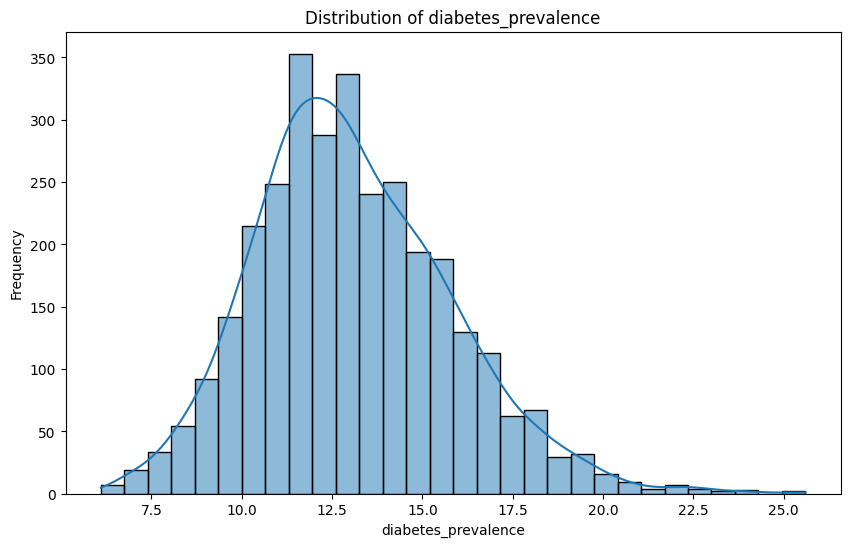

In [15]:
# Histogram of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df_baking[TARGET].dropna(), kde=True, bins=30)
plt.title(f'Distribution of {TARGET}')
plt.xlabel(TARGET)
plt.ylabel('Frequency')
plt.show()

In [16]:
# --- Bivariate Analysis (Scatter plots for numerical vs. target) ---
# Select a few numerical features to visualize against the target
numerical_features = df_baking.select_dtypes(include=np.number).columns.tolist()
if TARGET in numerical_features:
    numerical_features.remove(TARGET) # Remove target from features list

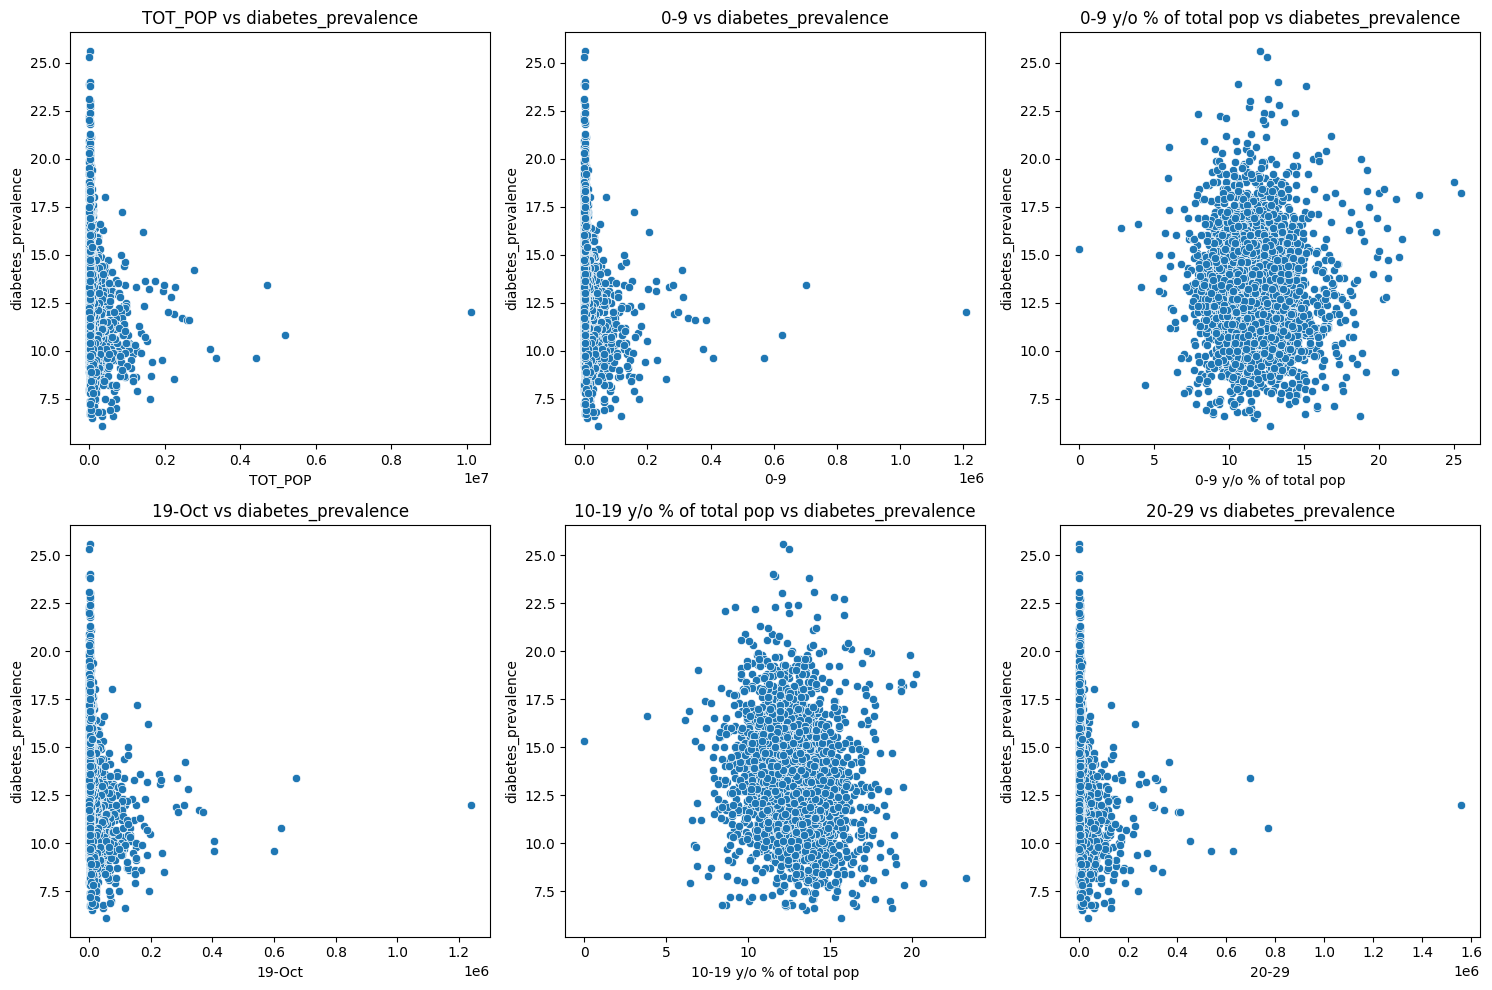

In [17]:
# Plotting scatter plots for a subset of numerical features against the target
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:6]): # Plotting first 6 for brevity
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=df_baking[feature], y=df_baking[TARGET])
    plt.title(f'{feature} vs {TARGET}')
    plt.xlabel(feature)
    plt.ylabel(TARGET)
plt.tight_layout()
plt.show()


Correlation Matrix:


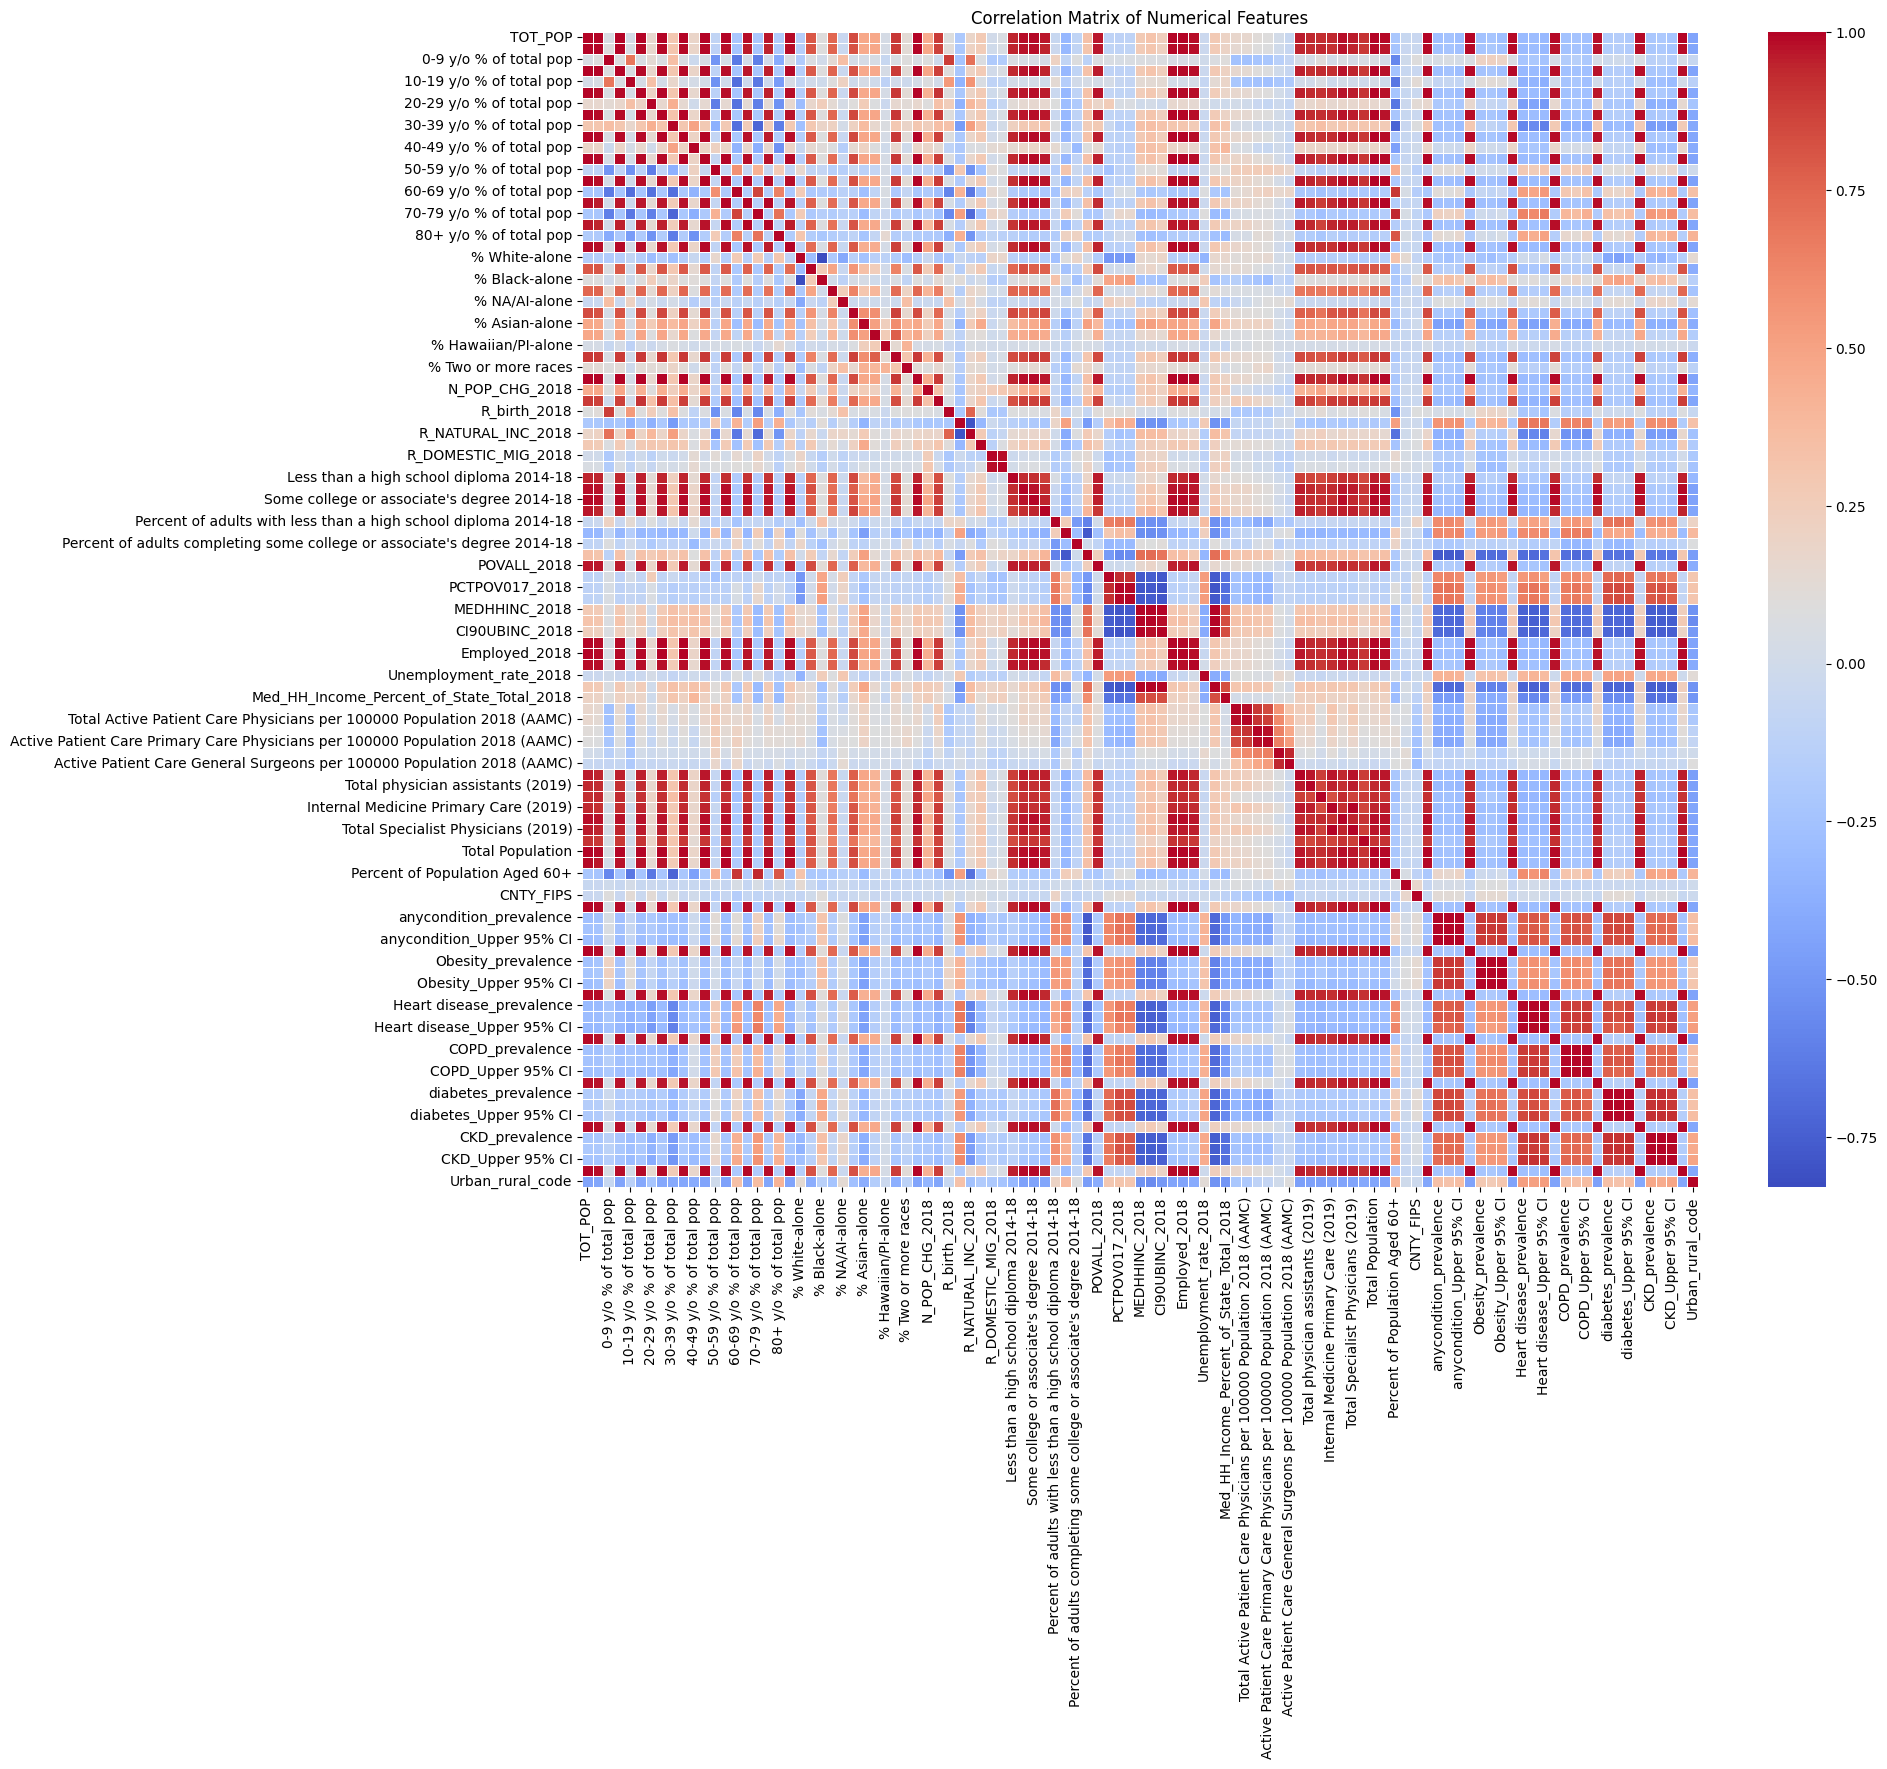

In [18]:
# --- Correlation Analysis ---
print("\nCorrelation Matrix:")
plt.figure(figsize=(18, 15))
corr_matrix = df_baking.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5) # annot=False for large matrices
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [19]:
# Display correlations with the target variable
print(f"\nCorrelations with {TARGET}:")
print(corr_matrix[TARGET].sort_values(ascending=False))


Correlations with diabetes_prevalence:
diabetes_prevalence                                             1.000000
diabetes_Upper 95% CI                                           0.998409
diabetes_Lower 95% CI                                           0.998069
CKD_Lower 95% CI                                                0.924630
CKD_prevalence                                                  0.918514
                                                                  ...   
Percent of adults with a bachelor's degree or higher 2014-18   -0.669985
CI90UBINC_2018                                                 -0.720364
CI90LBINC_2018                                                 -0.720820
Median_Household_Income_2018                                   -0.723316
MEDHHINC_2018                                                  -0.723316
Name: diabetes_prevalence, Length: 105, dtype: float64


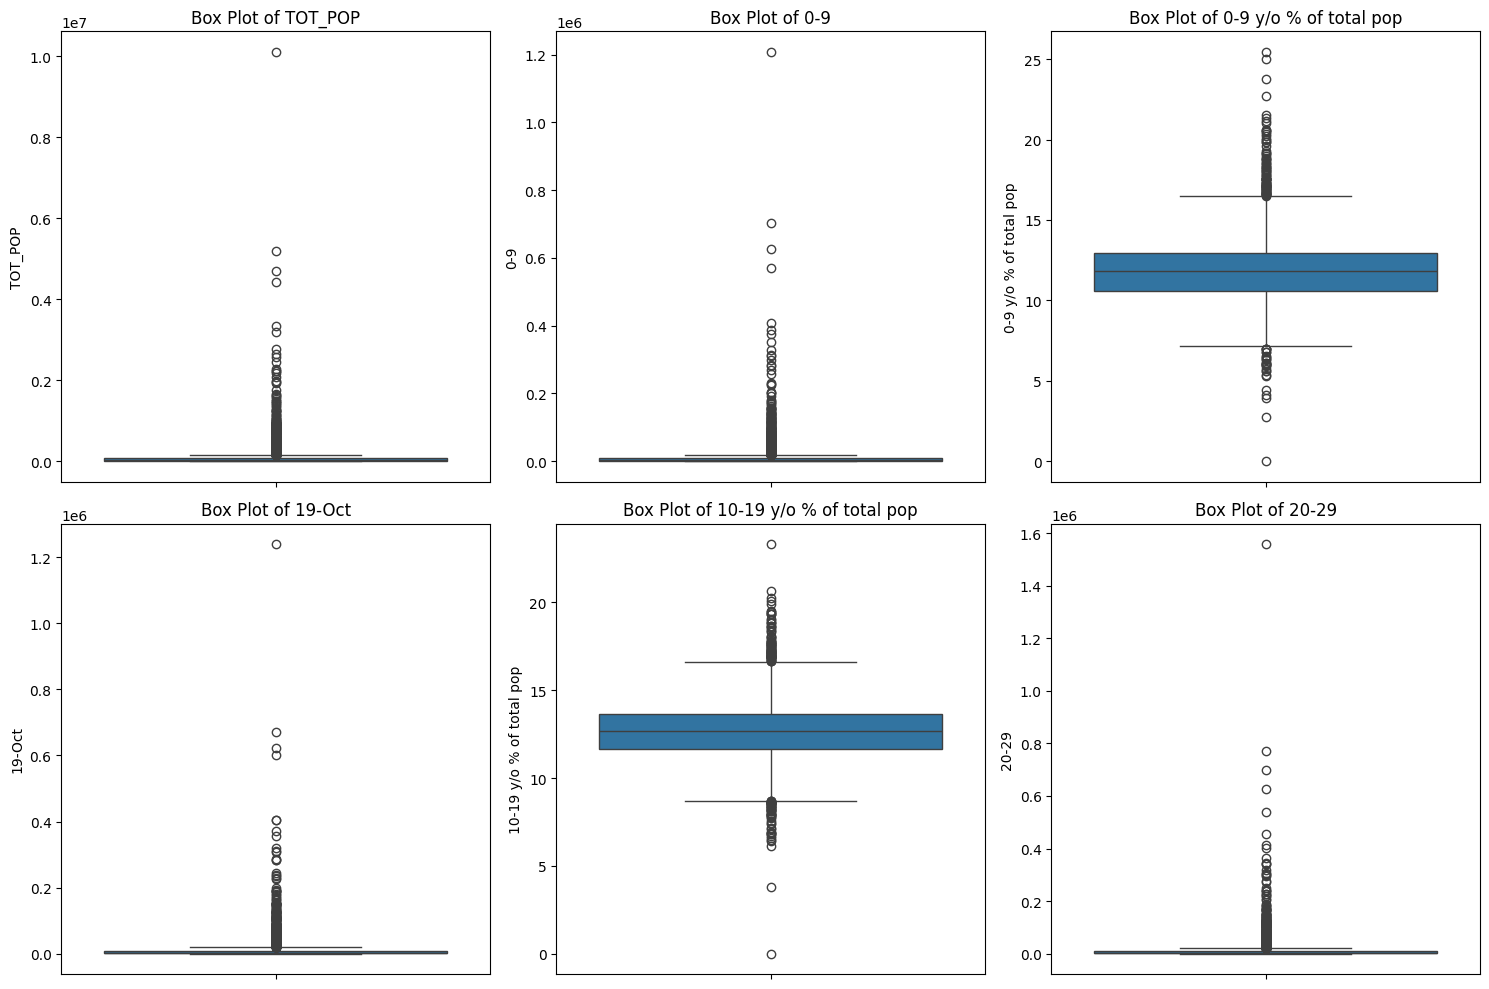

In [20]:
# --- Box Plots for Numerical Features (to check for outliers) ---
# Select a few numerical features for box plots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features[:6]): # Plotting first 6 for brevity
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df_baking[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

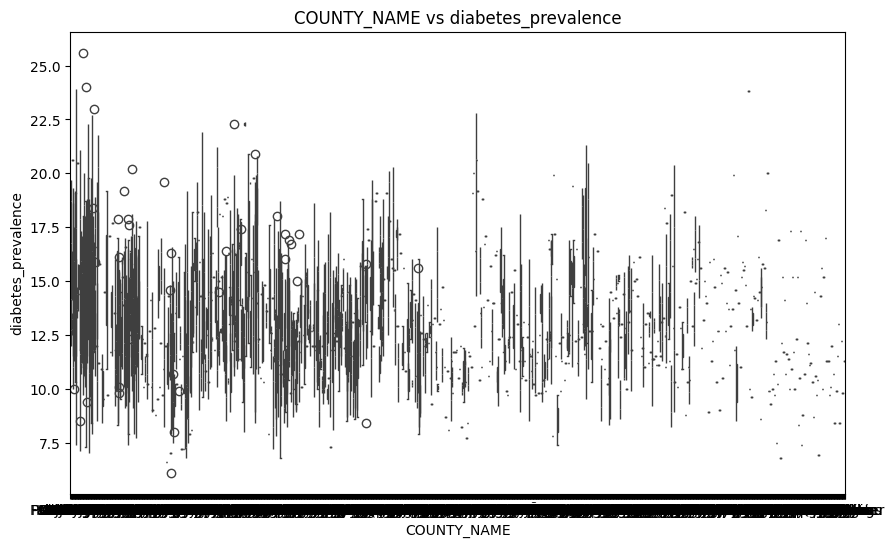

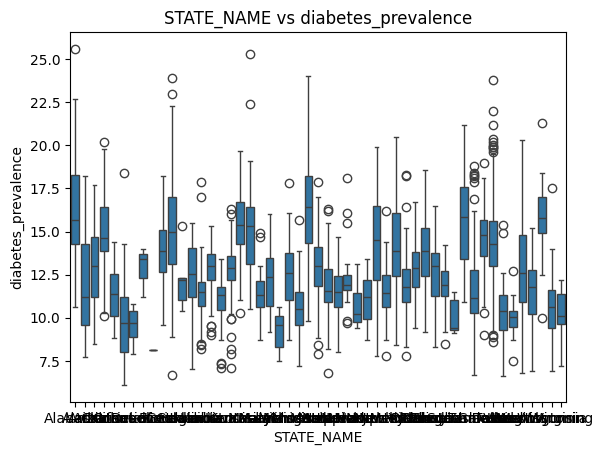

In [21]:
# --- Box Plots for Categorical vs. Target ---
categorical_features = df_baking.select_dtypes(include='object').columns.tolist()
if categorical_features:
    plt.figure(figsize=(10, 6))
    for cat_feature in categorical_features:
        sns.boxplot(x=df_baking[cat_feature], y=df_baking[TARGET])
        plt.title(f'{cat_feature} vs {TARGET}')
        plt.xlabel(cat_feature)
        plt.ylabel(TARGET)
        plt.show()

In [22]:
df = df_baking.copy()

In [23]:
# Handle missing values - Example: Impute numerical NaNs with mean, categorical with mode
# Numerical columns to impute (excluding the target if it has NaNs and we want to drop rows)
numerical_cols_to_impute = df.select_dtypes(include=np.number).columns.tolist()
if TARGET in numerical_cols_to_impute:
    numerical_cols_to_impute.remove(TARGET) # Don't impute target if we plan to drop rows with NaN target
    
for col in numerical_cols_to_impute:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())
        print(f"Missing values in numerical column '{col}' imputed with mean.")

for col in df.select_dtypes(include='object').columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"Missing values in categorical column '{col}' imputed with mode.")

# Drop rows where the target variable is NaN (if any)
initial_rows = df.shape[0]
df.dropna(subset=[TARGET], inplace=True)
if df.shape[0] < initial_rows:
    print(f"Dropped {initial_rows - df.shape[0]} rows due to NaN in target variable '{TARGET}'.")

print(f"\nFinal shape of 'df' after preprocessing: {df.shape}")
print(f"Missing values in 'df' after preprocessing: {df.isnull().sum().sum()}")


Final shape of 'df' after preprocessing: (3140, 107)
Missing values in 'df' after preprocessing: 0


In [24]:
## 2.4 Data Splitting (train, test, val)
print("\n--- Data Splitting ---")
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# Split df into df_train and df_test (80/20 split)
df_train_temp, df_test = train_test_split(df, test_size=0.2, random_state=42)
print(f"df_train_temp shape: {df_train_temp.shape}")
print(f"df_test shape: {df_test.shape}")

# Split df_train_temp into df_train and df_val (e.g., 75% of df_train_temp for train, 25% for val)
# This means df_train will be 60% of original, df_val will be 20% of original
df_train, df_val = train_test_split(df_train_temp, test_size=0.25, random_state=42) # 0.25 of 0.8 = 0.2
print(f"df_train shape: {df_train.shape}")
print(f"df_val shape: {df_val.shape}")


--- Data Splitting ---
df_train_temp shape: (2512, 107)
df_test shape: (628, 107)
df_train shape: (1884, 107)
df_val shape: (628, 107)


In [25]:
# Separate features (X) and target (y) for each set
X_train = df_train.drop(TARGET, axis=1)
y_train = df_train[TARGET]

X_val = df_val.drop(TARGET, axis=1)
y_val = df_val[TARGET]

X_test = df_test.drop(TARGET, axis=1)
y_test = df_test[TARGET]

print("\nData successfully split into training, validation, and test sets.")


Data successfully split into training, validation, and test sets.


### **4. Machine learning**
 **Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [26]:
# Identify numerical and categorical features for transformation
numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
# Imputation and Scaling for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Already imputed, but good practice for robust pipeline
    ('scaler', StandardScaler())
])

# Imputation and One-hot encoding for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Already imputed, but good practice
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [27]:
# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any, though none expected here
)

print("\nPreprocessing pipeline defined.")


Preprocessing pipeline defined.


In [28]:
## Baseline Linear Regression Model
print("\n--- Building Baseline Linear Regression Model ---")

# Create a pipeline that first preprocesses the data and then applies Linear Regression
from sklearn.pipeline import Pipeline
model_lr = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])


--- Building Baseline Linear Regression Model ---


In [29]:
# Train the model
model_lr.fit(X_train, y_train)
print("Linear Regression model trained.")

# Evaluate the baseline model on the validation set
y_val_pred_lr = model_lr.predict(X_val)
r2_lr = r2_score(y_val, y_val_pred_lr)
mse_lr = mean_squared_error(y_val, y_val_pred_lr)

print(f"Baseline Linear Regression R^2 on Validation Set: {r2_lr:.4f}")
print(f"Baseline Linear Regression Mean Squared Error on Validation Set: {mse_lr:.4f}")


Linear Regression model trained.
Baseline Linear Regression R^2 on Validation Set: 0.9995
Baseline Linear Regression Mean Squared Error on Validation Set: 0.0036


In [30]:
## 3.3 Lasso Regression Model
print("\n--- Building Lasso Regression Model ---")

# Create a pipeline for Lasso Regression
# Lasso adds regularization, so it can handle multicollinearity and perform feature selection
model_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', Lasso(random_state=42))])

# Train the Lasso model (with default alpha)
model_lasso.fit(X_train, y_train)
print("Lasso Regression model trained with default alpha.")


--- Building Lasso Regression Model ---
Lasso Regression model trained with default alpha.


In [31]:
# Evaluate the Lasso model on the validation set
y_val_pred_lasso_default = model_lasso.predict(X_val)
r2_lasso_default = r2_score(y_val, y_val_pred_lasso_default)
mse_lasso_default = mean_squared_error(y_val, y_val_pred_lasso_default)

print(f"Lasso Regression (Default Alpha) R^2 on Validation Set: {r2_lasso_default:.4f}")
print(f"Lasso Regression (Default Alpha) Mean Squared Error on Validation Set: {mse_lasso_default:.4f}")


Lasso Regression (Default Alpha) R^2 on Validation Set: 0.8634
Lasso Regression (Default Alpha) Mean Squared Error on Validation Set: 0.9346


In [32]:
# Comparison
print("\n--- Comparison of Baseline LR and Default Lasso ---")
print(f"R^2 difference (Lasso - LR): {r2_lasso_default - r2_lr:.4f}")


--- Comparison of Baseline LR and Default Lasso ---
R^2 difference (Lasso - LR): -0.1360


In [ ]:
## Analyze R^2 evolution with Lasso hyperparameter (alpha)
print("\n--- Analyzing R^2 vs. Lasso Alpha ---")
alphas = np.arange(0.0, 20.1, 0.1) # Test alpha from 0.0 to 20.0 with step 0.1
r2_scores = []
mse_scores = []

for alpha in alphas:
    # Lasso with specific alpha
    current_lasso_model = Pipeline(steps=[('preprocessor', preprocessor),
                                          ('regressor', Lasso(alpha=alpha, max_iter=10000, random_state=42))])
    # Suppress convergence warnings for alpha=0 if it occurs, as it's equivalent to Linear Regression
    if alpha == 0:
        current_lasso_model.fit(X_train, y_train)
    else:
        current_lasso_model.fit(X_train, y_train) # Fit as usual

    y_val_pred = current_lasso_model.predict(X_val)
    r2_scores.append(r2_score(y_val, y_val_pred))
    mse_scores.append(mean_squared_error(y_val, y_val_pred))


--- Analyzing R^2 vs. Lasso Alpha ---


/workspaces/regularized_linear_regresion_project_tutorial/.venv/lib/python3.11/site-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)


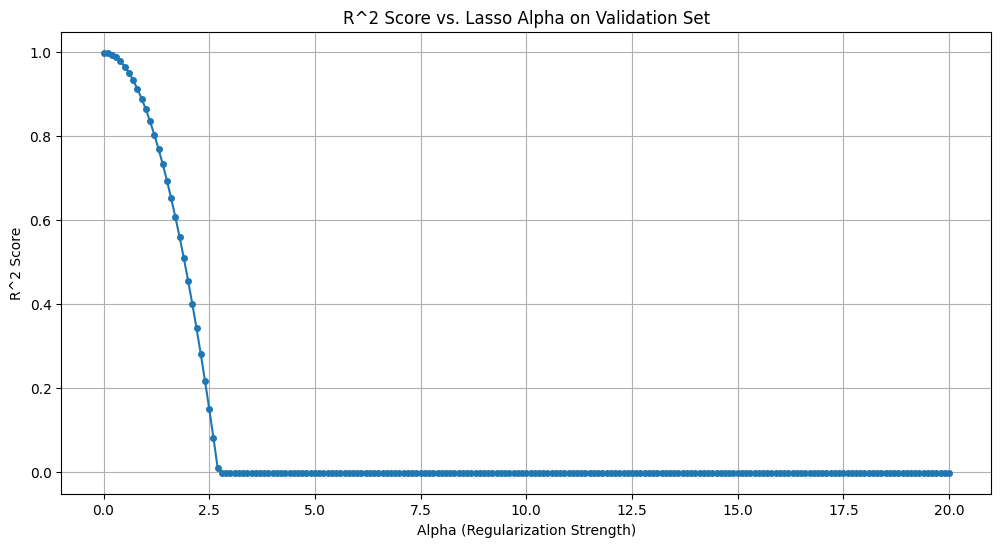

In [34]:
# Plot R^2 evolution
plt.figure(figsize=(12, 6))
plt.plot(alphas, r2_scores, marker='o', linestyle='-', markersize=4)
plt.title('R^2 Score vs. Lasso Alpha on Validation Set')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('R^2 Score')
plt.grid(True)
plt.show()

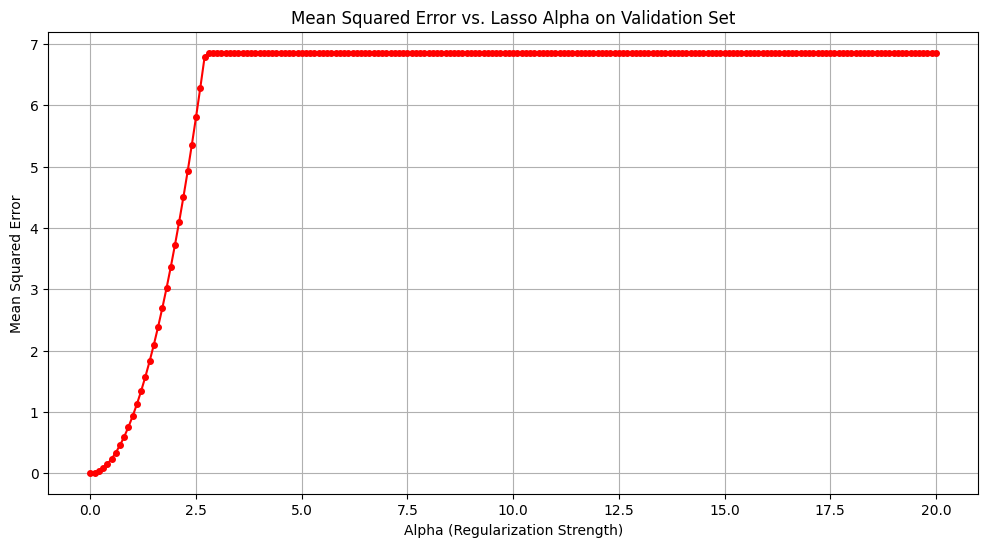

In [35]:
# Plot MSE evolution (optional, but good for understanding)
plt.figure(figsize=(12, 6))
plt.plot(alphas, mse_scores, marker='o', linestyle='-', markersize=4, color='red')
plt.title('Mean Squared Error vs. Lasso Alpha on Validation Set')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

In [36]:
# Find the best alpha from this range
best_alpha_r2 = alphas[np.argmax(r2_scores)]
max_r2 = np.max(r2_scores)
print(f"Best Alpha for R^2: {best_alpha_r2:.2f} with R^2: {max_r2:.4f}")

Best Alpha for R^2: 0.00 with R^2: 0.9984


In [37]:
# --- Optimize the previous linear regression model using python ---

## Hyperparameter Tuning for Lasso using GridSearchCV
print("\n--- Optimizing Lasso Model with GridSearchCV ---")

# Define the parameter grid for Lasso
# We'll search around the best_alpha_r2 found in the previous step
param_grid = {
    'regressor__alpha': np.linspace(max(0.001, best_alpha_r2 - 0.5), best_alpha_r2 + 0.5, 10), # Refine around best_alpha_r2
}
# Add more alphas if the previous search indicated a need for a wider range, e.g.,
# 'regressor__alpha': np.logspace(-3, 1, 50) # for a wider logarithmic search

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model_lasso,
                           param_grid=param_grid,
                           scoring='r2', # Use R^2 as the scoring metric
                           cv=5, # 5-fold cross-validation
                           n_jobs=-1, # Use all available CPU cores
                           verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

print("\nGridSearchCV completed.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R^2 score with best parameters (from CV): {grid_search.best_score_:.4f}")



--- Optimizing Lasso Model with GridSearchCV ---
Fitting 5 folds for each of 10 candidates, totalling 50 fits

GridSearchCV completed.
Best parameters found: {'regressor__alpha': np.float64(0.001)}
Best R^2 score with best parameters (from CV): 0.9997


In [38]:
# Get the best estimator (the optimized Lasso model)
best_lasso_model = grid_search.best_estimator_
print("\nOptimized Lasso model obtained.")


Optimized Lasso model obtained.


In [40]:
## Evaluate the Optimized Lasso Model on the Validation Set
print("\n--- Evaluating Optimized Lasso Model on Validation Set ---")
y_val_pred_optimized_lasso = best_lasso_model.predict(X_val)

r2_optimized_lasso = r2_score(y_val, y_val_pred_optimized_lasso)
mse_optimized_lasso = mean_squared_error(y_val, y_val_pred_optimized_lasso)

print(f"Optimized Lasso Regression R^2 on Validation Set: {r2_optimized_lasso:.4f}")
print(f"Optimized Lasso Regression Mean Squared Error on Validation Set: {mse_optimized_lasso:.4f}")



--- Evaluating Optimized Lasso Model on Validation Set ---
Optimized Lasso Regression R^2 on Validation Set: 0.9997
Optimized Lasso Regression Mean Squared Error on Validation Set: 0.0019


In [40]:
## Final Evaluation on the Test Set
print("\n--- Final Evaluation on Test Set ---")
y_test_pred_optimized_lasso = best_lasso_model.predict(X_test)

r2_test = r2_score(y_test, y_test_pred_optimized_lasso)
mse_test = mean_squared_error(y_test, y_test_pred_optimized_lasso)
rmse_test = np.sqrt(mse_test) # Root Mean Squared Error

print(f"Optimized Lasso Regression R^2 on Test Set: {r2_test:.4f}")
print(f"Optimized Lasso Regression Mean Squared Error on Test Set: {mse_test:.4f}")
print(f"Optimized Lasso Regression Root Mean Squared Error on Test Set: {rmse_test:.4f}")




--- Final Evaluation on Test Set ---
Optimized Lasso Regression R^2 on Test Set: 0.9997
Optimized Lasso Regression Mean Squared Error on Test Set: 0.0021
Optimized Lasso Regression Root Mean Squared Error on Test Set: 0.0458


### Visualizations for Model Evaluation

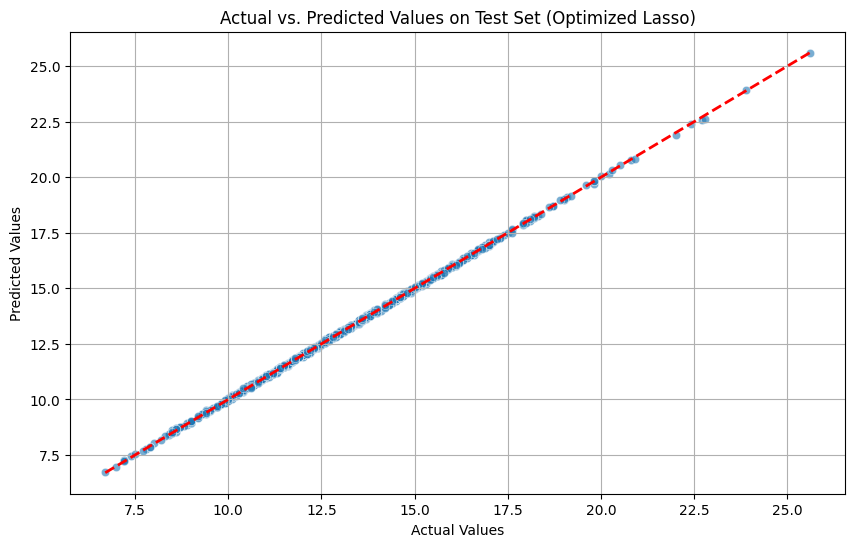

In [41]:
# --- Visualizations for Model Evaluation ---

# Plotting Predicted vs. Actual values for Test Set
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred_optimized_lasso, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values on Test Set (Optimized Lasso)')
plt.grid(True)
plt.show()


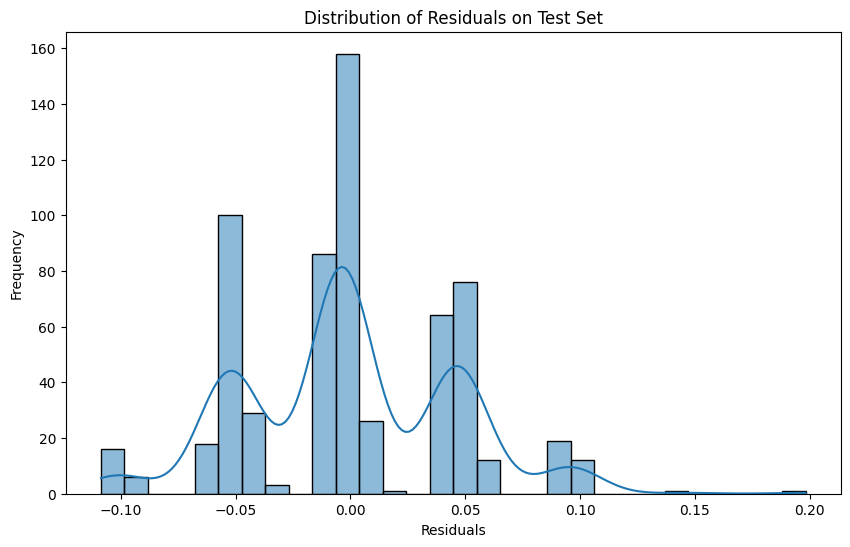

In [42]:
# Plotting Residuals
residuals = y_test - y_test_pred_optimized_lasso
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Residuals on Test Set')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

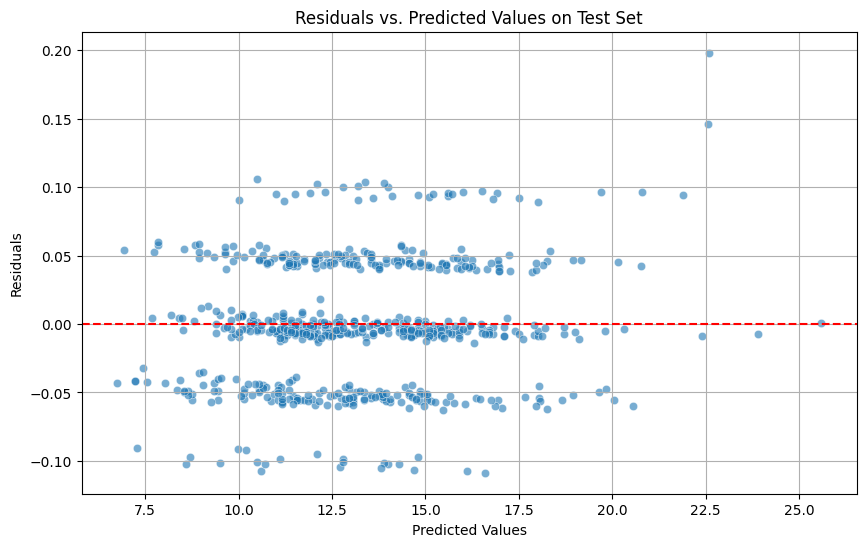

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_pred_optimized_lasso, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values on Test Set')
plt.grid(True)
plt.show()

### Table of Metrics

In [44]:
print("\n--- Model Evaluation Metrics ---")
metrics_data = {
    'Metric': ['R^2 (Validation - Baseline LR)', 'MSE (Validation - Baseline LR)',
               'R^2 (Validation - Default Lasso)', 'MSE (Validation - Default Lasso)',
               'R^2 (Validation - Optimized Lasso)', 'MSE (Validation - Optimized Lasso)',
               'R^2 (Test - Optimized Lasso)', 'MSE (Test - Optimized Lasso)',
               'RMSE (Test - Optimized Lasso)'],
    'Value': [f"{r2_lr:.4f}", f"{mse_lr:.4f}",
              f"{r2_lasso_default:.4f}", f"{mse_lasso_default:.4f}",
              f"{r2_optimized_lasso:.4f}", f"{mse_optimized_lasso:.4f}",
              f"{r2_test:.4f}", f"{mse_test:.4f}", f"{rmse_test:.4f}"]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))



--- Model Evaluation Metrics ---
                            Metric  Value
    R^2 (Validation - Baseline LR) 0.9995
    MSE (Validation - Baseline LR) 0.0036
  R^2 (Validation - Default Lasso) 0.8634
  MSE (Validation - Default Lasso) 0.9346
R^2 (Validation - Optimized Lasso) 0.9997
MSE (Validation - Optimized Lasso) 0.0019
      R^2 (Test - Optimized Lasso) 0.9997
      MSE (Test - Optimized Lasso) 0.0021
     RMSE (Test - Optimized Lasso) 0.0458


### **General Conclusions**
- **Strong Relationship**: results, especially the very high R2 in the baseline linear model and the optimized Lasso, suggest that there is a very strong and predictable linear relationship between the sociodemographic and health resource characteristics and the prevalence of diabetes. The model is able to explain almost all of the variability in diabetes prevalence.

- **Importance of Regularization (and Optimization)**: The drastic deterioration in performance with the default Lasso and its recovery with the optimized Lasso demonstrate the importance of hyperparameter tuning (alpha) for the regularized model. An inadequate alpha can lead to underfitting, while a well-chosen alpha allows the model to take advantage of the benefits of regularization (such as feature selection) without sacrificing predictive power.

- **Excellent Generalization**: The consistency of performance metrics between the validation set and the test set for the optimized Lasso model is an excellent sign that your model is not overfitting and that its predictions are reliable on unseen data.

In [45]:
# --- Step 5: Save the model ---
print("\n--- Saving the Optimized Model ---")
model_filename = 'optimized_lasso_regression_model.joblib'
joblib.dump(best_lasso_model, model_filename)
print(f"Model saved as '{model_filename}' in the current directory.")


--- Saving the Optimized Model ---
Model saved as 'optimized_lasso_regression_model.joblib' in the current directory.
